In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj

from scipy.interpolate import griddata

In [117]:
plt.rcParams.update({
    "font.size": 18, 
    "grid.alpha": 0.2,})

### Read the .csv files

In [126]:
bathymetry_scatter_nodes = 'scatter-nodes.csv'
bathymetry_contour_nodes = 'contour-nodes.csv'
bathymetry_contour_attr = 'contour-attributes.csv'

In [127]:
df_scatter = pd.read_csv(bathymetry_scatter_nodes, header=0, usecols=["x", "y", "ScatterPoint"])
df_scatter = df_scatter.rename(columns={"ScatterPoint": "depth"})
df_scatter

,x,y,depth
0,125.160277,32.152880,51.0
1,125.162744,32.152807,51.0
2,125.165338,32.152786,51.0
3,125.161486,32.151713,51.0
4,125.160274,32.150767,51.0
...,...,...,...
863,125.175411,32.143073,50.0
864,125.173167,32.142221,50.0
865,125.183130,32.131009,30.0
866,125.178754,32.113908,50.0


In [128]:
df_contour = pd.read_csv(bathymetry_contour_nodes, header=0, usecols=["x", "y", "shapeid"])
df_contour

,shapeid,x,y
0,0,125.180440,32.128644
1,0,125.180414,32.128627
2,0,125.180391,32.128603
3,0,125.180380,32.128584
4,0,125.180379,32.128544
...,...,...,...
2855,4,125.189368,32.127861
2856,4,125.189386,32.127940
2857,4,125.189420,32.128017
2858,4,125.189466,32.128098


In [129]:
df_contour_attr = pd.read_csv(bathymetry_contour_attr, header=0, usecols=["shapeid", "ContourLine"])
df_contour_attr

,shapeid,ContourLine
0,0,5
1,1,10
2,2,20
3,3,30
4,4,50


In [130]:
df_contour["depth"] = df_contour_attr["ContourLine"].iloc[df_contour["shapeid"]].values
df_contour = df_contour.drop(['shapeid'], axis=1)
df_contour

,x,y,depth
0,125.180440,32.128644,5
1,125.180414,32.128627,5
2,125.180391,32.128603,5
3,125.180380,32.128584,5
4,125.180379,32.128544,5
...,...,...,...
2855,125.189368,32.127861,50
2856,125.189386,32.127940,50
2857,125.189420,32.128017,50
2858,125.189466,32.128098,50


In [133]:
df_lon_lat_depth = pd.concat([df_scatter, df_contour], ignore_index=True)
df_lon_lat_depth = df_lon_lat_depth.rename(columns={"x": "lon", "y": "lat"})
df_lon_lat_depth

,lon,lat,depth
0,125.160277,32.152880,51.0
1,125.162744,32.152807,51.0
2,125.165338,32.152786,51.0
3,125.161486,32.151713,51.0
4,125.160274,32.150767,51.0
...,...,...,...
3723,125.189368,32.127861,50.0
3724,125.189386,32.127940,50.0
3725,125.189420,32.128017,50.0
3726,125.189466,32.128098,50.0


### Save bathy to .csv for visualization using MATLAB

In [135]:
df_lon_lat_depth.to_csv("Ieodo_lon_lat_depth.csv", index=False)

In [139]:
df_scatter_saved = df_scatter.rename(columns={"x": "lon", "y": "lat"})
df_scatter_saved.to_csv("Ieodo_lon_lat_depth_scatterOnly.csv", index=False)

### Convert lon/lat to UTM easting/northing

In [102]:
ieodo_utm_zone = "51"
ieodo_lon_lat = [125.18050, 32.12855]     # at summit 4.6 m

mapProj = pyproj.Proj(proj="utm", zone=ieodo_utm_zone, ellps="WGS84")

In [103]:
ref_x, ref_y = mapProj(ieodo_lon_lat[0], ieodo_lon_lat[1])
UTM_x, UTM_y = mapProj(df_lon_lat_depth["x"].values, df_lon_lat_depth["y"].values)

UTM_x = UTM_x - ref_x
UTM_y = UTM_y - ref_y

scatterPoints = np.hstack([UTM_x[:, np.newaxis], UTM_y[:, np.newaxis]])
scatterPoints.shape

(3728, 2)

### Interpolate scatter points

In [104]:
min_UTM_x = np.min(UTM_x)
max_UTM_x = np.max(UTM_x)

min_UTM_y = np.min(UTM_y)
max_UTM_y = np.max(UTM_y)

Nx = 256
Ny = 256

x_space = np.linspace(min_UTM_x, max_UTM_x, Nx)
y_space = np.linspace(min_UTM_y, max_UTM_y, Ny)

x_mesh, y_mesh = np.meshgrid(x_space, y_space)

depth_mesh = griddata(scatterPoints, df_lon_lat_depth["depth"].values, 
    (x_mesh, y_mesh), method="cubic")

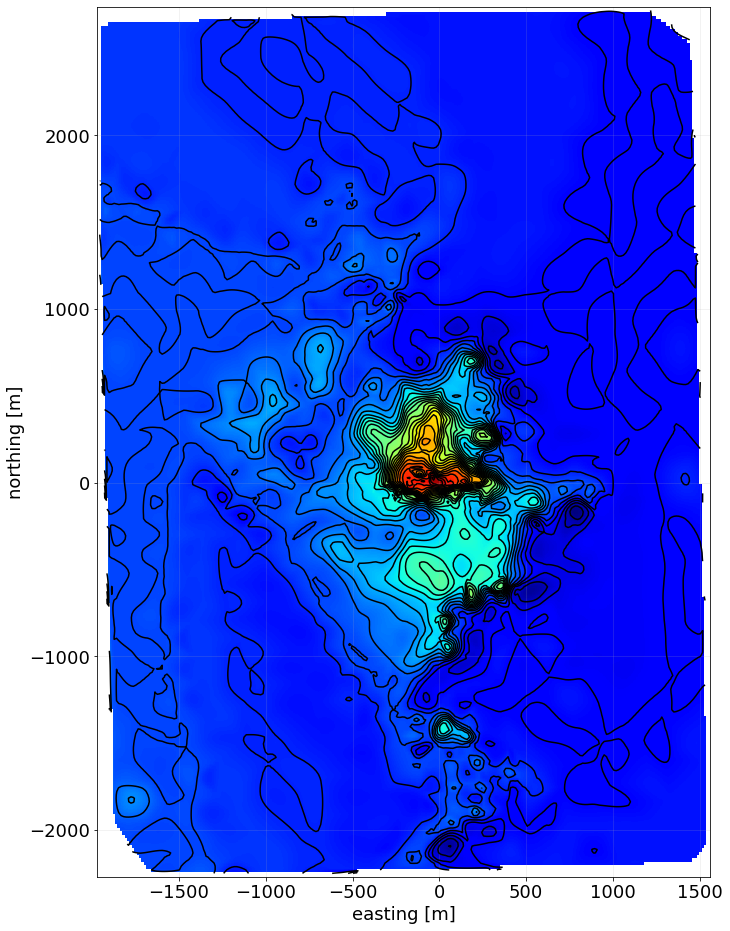

In [113]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.imshow(depth_mesh, extent=(min_UTM_x, max_UTM_x, min_UTM_y, max_UTM_y), origin="lower", cmap="jet_r")

#contourLevels = [5, 10, 20,  30, 50]
contourLevels = np.arange(0, 60+2, 2)
ax.contour(x_mesh, y_mesh, depth_mesh, contourLevels, colors='k')

ax.set_aspect("equal")
ax.set_xlabel("easting [m]")
ax.set_ylabel("northing [m]")
ax.grid("on")

plt.show(fig)